In [1]:
!pip install -q --upgrade wandb
!pip install sentence_transformers
!pip install flair
!pip install --upgrade urllib3
!pip install --upgrade transformers
!pip install -q bitsandbytes-cuda110
!pip install sentencepiece
!pip install bitsandbytes

  Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.1
    Uninstalling urllib3-2.2.1:
      Successfully uninstalled urllib3-2.2.1
  Using cached urllib3-2.2.1-py3-none-any.whl (121 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flair 0.13.1 requires urllib3<2.0.0,>=1.0.0, but you have urllib3 2.2.1 which is incompatible.


In [2]:
# Manipulation

import pandas as pd
import numpy as np
import os
import pickle

# NLP

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.util import ngrams
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import string
import gensim.downloader as api
from gensim import corpora
from gensim.models import LdaModel
from flair.models import TextClassifier
from flair.data import Sentence
from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

# PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adagrad, Adam, SGD, lr_scheduler
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.utils.checkpoint import checkpoint
from torch.autograd import Variable

# Wandb

import wandb
import tokenizers

# Transformers

import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
from transformers.models.deberta_v2.modeling_deberta_v2 import StableDropout, ContextPooler
from sentence_transformers import SentenceTransformer

# Sklearn

from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Other

import matplotlib.pyplot as plt
import joblib
import gc
import copy
import time
from tqdm import tqdm
from collections import defaultdict
import bitsandbytes as bnb
import math
import warnings,logging

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys

INPUT_DIR = 'data'

sty_path = "stylometry_extractor.pkl"

from redditparser import Reddit_Parser

TEST_CSV = os.path.join(INPUT_DIR, 'eval-table-mediumparser.csv')

raw_df = pd.read_csv(TEST_CSV)
test_df = pd.read_csv(TEST_CSV)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
raw_df.iloc[915]

Paragraphs1      In general, be courteous to others. Debate/discuss/argue the merits of ideas, don't attack people. Personal insults, shill or troll accusations, hate speech, any suggestion or support of harm, violence, or death, and other rule violations can result in a permanent ban.
Paragraphs2                                                                                                   For those who have questions regarding any media outlets being posted on this subreddit, please click to review our details as to our approved domains list and outlet criteria.
Truth_changes                                                                                                                                                                                                                                                                                0
file_number                                                                                                                                

In [5]:
test_df['Majority_baseline'] = 1
report = classification_report(test_df['Truth_changes'], test_df['Majority_baseline'], output_dict=True)

for class_label, metrics in report.items():
    if class_label != 'accuracy':
        print(f"Class: {class_label}")
        for metric_name, value in metrics.items():
            # Format numbers to desired precision
            if isinstance(value, float):
                value = "{:.5f}".format(value)  # Adjust the precision as needed
            print(f"{metric_name}: {value}")
        print()
    else:
        print(f"Overall accuracy: {metrics:.5f}")

Class: 0
precision: 0.44266
recall: 0.52589
f1-score: 0.48070
support: 1989

Class: 1
precision: 0.57694
recall: 0.49405
f1-score: 0.53228
support: 2603

Overall accuracy: 0.50784
Class: macro avg
precision: 0.50980
recall: 0.50997
f1-score: 0.50649
support: 4592

Class: weighted avg
precision: 0.51878
recall: 0.50784
f1-score: 0.50994
support: 4592



# SFN

# Preprocess test set for SFN

## Sentence BERT

In [6]:
sbert_path = 'weights/Siamese/fine-tuned-S-BERT'
sbert = SentenceTransformer(sbert_path)

embeddings1 = []
embeddings2 = []
arr1 = test_df['Paragraphs1'].tolist()
arr2 = test_df['Paragraphs2'].tolist()

for s in arr1:
    s = sbert.encode(s)
    embeddings1.append(s)
    if len(embeddings1) % 1000 == 0:
      print(len(embeddings1))

for s in arr2:
    s = sbert.encode(s)
    embeddings2.append(s)
    if len(embeddings2) % 1000 == 0:
      print(len(embeddings2))

test_df['Embeddings1'] = embeddings1
test_df['Embeddings2'] = embeddings2

1000
2000
3000
4000
1000
2000
3000
4000


## Stylometry

In [7]:
class StylometryExtractor():
    def __init__(self, corpus):
        self.corpus = corpus
        self.embedding_vocab = api.load("glove-wiki-gigaword-300")
        self.top_100_common_words = None
        self.top_10_common_adjectives = None
        self.top_10_common_conjunctions = None
        self.top_10_common_interrogatives = None
        self.top_10_common_nouns = None
        self.top_10_common_verbs = None
        self.top_30_common_three_grams = None
        self.top_30_common_five_grams = None
        self.top_100_common_oov_embeddings = None
        self.top_100_common_tri_grams = None
        self.top_100_common_five_grams = None

    def is_consonant(self, char):
        consonant_pattern = re.compile(r'[bcdfghjklmnpqrstvwxyz]', re.IGNORECASE)
        return bool(consonant_pattern.match(char))

    def is_vowel(self, char):
        vowel_pattern = re.compile(r'[aeiou]', re.IGNORECASE)
        return bool(vowel_pattern.match(char))

    def preprocess_corpus(self):

        corpus = self.corpus
        print("Saved corpus variable")

        # Preprocessing step

        corpus_lower = corpus.lower()
        print("lowered")
        tokens = word_tokenize(corpus_lower)
        print("tokenized")
        tagged_tokens = pos_tag(tokens)
        print("pos_tagged")
        freq_dist = FreqDist(tagged_tokens)
        freq_dist_no_tag = FreqDist(tokens)
        print("general freq dist done")
        vocabulary = freq_dist_no_tag.keys()
        print("vocabulary initialized")
        adjectives = [word for word, tag in tagged_tokens if tag.startswith('JJ')]
        print("adjectives done")
        conjunctions = [word for word, tag in tagged_tokens if tag.startswith('CC')]
        print("conjunctions done")
        interrogatives = [word for word, tag in tagged_tokens if tag in ['WP', 'WRB']]
        print("interrogatives done")
        nouns = [word for word, tag in tagged_tokens if tag in ['NN', 'NNS', 'NNPS', 'NNP']]
        print("nouns done")
        verbs = [word for word, tag in tagged_tokens if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]
        print("verbs done")
        three_grams = list(ngrams(tokens, 3))
        print("3grams done")
        five_grams = list(ngrams(tokens, 5))
        print("5grams done")
        oov_embeddings = [word for word in vocabulary if word not in self.embedding_vocab]
        print("oov done")

        ''''''
        freq_dist_adjectives = FreqDist(adjectives)
        print("collected freq_dists for adjectives")
        freq_dist_conjunctions = FreqDist(conjunctions)
        print("collected freq_dists for conjunctions")
        freq_dist_interrogatives = FreqDist(interrogatives)
        print("collected freq_dists for interrogatives")
        freq_dist_nouns = FreqDist(nouns)
        print("collected freq_dists for nouns")
        freq_dist_verbs = FreqDist(verbs)
        print("collected freq_dists for verbs")
        freq_dist_oov_embeddings = FreqDist(oov_embeddings)
        print("collected freq_dists for oovs")
        freq_dist_three_grams = FreqDist(three_grams)
        print("collected freq_dists for 3grams")
        freq_dist_five_grams = FreqDist(five_grams)
        print("collected freq_dists for 5grams")

        ''''''
        print("starting collecting most commons")
        self.top_100_common_words = [x[0] for x in freq_dist.most_common(100)]
        self.top_10_common_adjectives = [x[0] for x in freq_dist_adjectives.most_common(10)]
        self.top_10_common_conjunctions = [x[0] for x in freq_dist_conjunctions.most_common(10)]
        self.top_10_common_interrogatives = [x[0] for x in freq_dist_interrogatives.most_common(10)]
        self.top_10_common_nouns = [x[0] for x in freq_dist_nouns.most_common(10)]
        self.top_10_common_verbs = [x[0] for x in freq_dist_verbs.most_common(10)]
        self.top_30_common_three_grams = [x[0] for x in freq_dist_three_grams.most_common(30)]
        self.top_30_common_five_grams = [x[0] for x in freq_dist_five_grams.most_common(30)]
        self.top_100_common_oov_embeddings = [x[0] for x in freq_dist_oov_embeddings.most_common(100)]
        self.top_100_common_tri_grams = [x[0] for x in freq_dist_five_grams.most_common(100)]
        self.top_100_common_five_grams = [x[0] for x in freq_dist_three_grams.most_common(100)]

        # Update init to save info about the corpus

    def get_values(self, value):

        if value == 'words':
            return self.top_100_common_words
        elif value == 'adjectives':
            return self.top_10_common_adjectives
        elif value == 'conjunctions':
            return self.top_10_common_conjunctions
        elif value == 'interrogatives':
            return self.top_10_common_interrogatives
        elif value == 'nouns':
            return self.top_10_common_nouns
        elif value == 'verbs':
            return self.top_10_common_verbs
        elif value == 'three_grams':
            return self.top_30_common_three_grams
        elif value == 'five_grams':
            return self.top_30_common_five_grams
        elif value == 'oov':
            return self.top_100_common_oov_embeddings
        else:
            ValueError('Set value')

    def stylometry_extractor(self, paragraph, character_level=True, word_level=True, sentence_level=True):

        # Some init
        F = np.array([])
        F = F.reshape(-1)
        F_chars = np.zeros(104)
        F_words = np.zeros(60)
        F_sents = np.zeros(220)

        epsilon = 1e-10

        # Preprocess paragraph
        sentences = sent_tokenize(paragraph)
        tokens = word_tokenize(paragraph)
        paragraph_lower = paragraph.lower()
        tokens_lower = word_tokenize(paragraph_lower)
        pos_tagged_tokens = pos_tag(tokens)
        parts_of_speech = [x[1] for x in pos_tagged_tokens]

        # Set regexs

        punctuation = r'[\W_]+'
        other_things = r'[^a-zA-Z0-9\s\\p{P}]'
        words = len(tokens)

        # Character level

        chars_list = list(paragraph_lower)
        chars = len(list(paragraph_lower))
        alphas = len([char for char in chars_list if char.isalpha()])
        uppers = len([char for char in list(paragraph) if char.isupper()])
        digits = len([char for char in chars_list if char.isdigit()])
        whitespaces = len([char for char in chars_list if char == ' '])
        vowels = len([char for char in paragraph if char.lower() in 'aeiou'])
        char_two_grams = len([''.join(gram) for gram in list(ngrams(chars_list, 2))])
        consonant_vowel_twograms = len([''.join(gram) for gram in ngrams(chars_list, 2) if re.match(r'[bcdfghjklmnpqrstvwxyz][aeiou]', ''.join(gram))])
        vowel_consonant_twograms = len([''.join(gram) for gram in ngrams(chars_list, 2) if re.match(r'[aeiou][bcdfghjklmnpqrstvwxyz]', ''.join(gram))])
        consonant_consonant_twograms = len([''.join(gram) for gram in ngrams(chars_list, 2) if re.match(r'[bcdfghjklmnpqrstvwxyz][bcdfghjklmnpqrstvwxyz]', ''.join(gram))])
        vowel_vowel_twograms = len([''.join(gram) for gram in ngrams(chars_list, 2) if re.match(r'[aeiou][aeiou]', ''.join(gram))])

        # Word level

        word_three_grams = list(ngrams(tokens, 3))
        word_five_grams = list(ngrams(tokens, 5))

        # Sentence level

        puncts = len(re.findall(punctuation, paragraph))
        others = len(re.findall(other_things, paragraph))
        pp = len([pos_tag for pos_tag in parts_of_speech if pos_tag.startswith('PRP')])
        adj = len([pos_tag for pos_tag in parts_of_speech if pos_tag.startswith('JJ')])
        conj = len([pos_tag for pos_tag in parts_of_speech if pos_tag.startswith('CC')])
        aux = len([pos_tag for pos_tag in parts_of_speech if pos_tag.startswith('MD')])
        interr = len([pos_tag for pos_tag in parts_of_speech if pos_tag in ['WP', 'WRB']])
        nouns = len([pos_tag for pos_tag in parts_of_speech if pos_tag in ['NN', 'NNS', 'NNPS', 'NNP']])
        verbs = len([pos_tag for pos_tag in parts_of_speech if pos_tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']])
        dets = len([pos_tag for pos_tag in parts_of_speech if pos_tag.startswith('DT')])
        articles = len([token for token in tokens_lower if token in ["a", "an", "the"]])
        sents = len(nltk.sent_tokenize(paragraph))
        top100_common_words = [word for word, _ in self.top_100_common_words]

        # Build feature vector

        freq_cons_0 = ["t", "n", "s", "r", "h"]
        count_freq_cons_0 = sum(paragraph_lower.count(char) for char in freq_cons_0)
        freq_cons_1 = ["l", "d", "c", "p", "f"]
        count_freq_cons_1 = sum(paragraph_lower.count(char) for char in freq_cons_1)
        freq_cons_2 = ["m", "w", "y", "b", "g"]
        count_freq_cons_2 = sum(paragraph_lower.count(char) for char in freq_cons_2)
        freq_cons_3 = ["j", "k", "q", "v", "x", "z"]
        count_freq_cons_3 = sum(paragraph_lower.count(char) for char in freq_cons_3)
        to_be_verbs = [r'\b(am)\b', r'\b(are)\b', r'\b(be)\b', r'\b(been)\b', r'\b(being)\b', r'\b(is)\b', r'\b(was)\b', r'\b(were)\b']
        count_to_be_verbs = sum(paragraph_lower.count(word) for word in to_be_verbs)

        def count_missed_uppercase(tokens):
            missed_uppercase_count = 0

            for i in range(len(tokens) - 1):
                if tokens[i] == '.' and tokens[i+1][0].islower():
                    missed_uppercase_count += 1

            return missed_uppercase_count

        def count_missing_periods(sentences):
            missing_period_count = 0

            for sentence in sentences:
                if sentence[-1] != '.':
                    missing_period_count += 1

            return missing_period_count

        if character_level:
            F_chars = [
                alphas/(chars + epsilon),
                uppers/(chars + epsilon),
                digits/(chars + epsilon),
                whitespaces/(chars + epsilon),
                vowels/(chars + epsilon),
                paragraph_lower.count("a")/(vowels + epsilon),
                paragraph_lower.count("e")/(vowels + epsilon),
                paragraph_lower.count("i")/(vowels + epsilon),
                paragraph_lower.count("o")/(vowels + epsilon),
                paragraph_lower.count("u")/(vowels + epsilon),
                paragraph_lower.count("a")/(chars + epsilon),
                count_freq_cons_0/(alphas + epsilon),
                count_freq_cons_1/(alphas + epsilon),
                count_freq_cons_2/(alphas + epsilon),
                count_freq_cons_3/(alphas + epsilon),
                paragraph_lower.count("t")/(count_freq_cons_0 + epsilon),
                paragraph_lower.count("n")/(count_freq_cons_0 + epsilon),
                paragraph_lower.count("s")/(count_freq_cons_0 + epsilon),
                paragraph_lower.count("r")/(count_freq_cons_0 + epsilon),
                paragraph_lower.count("h")/(count_freq_cons_0 + epsilon),
                paragraph_lower.count("l")/(count_freq_cons_1 + epsilon),
                paragraph_lower.count("d")/(count_freq_cons_1 + epsilon),
                paragraph_lower.count("c")/(count_freq_cons_1 + epsilon),
                paragraph_lower.count("p")/(count_freq_cons_1 + epsilon),
                paragraph_lower.count("f")/(count_freq_cons_1 + epsilon),
                paragraph_lower.count("m")/(count_freq_cons_2 + epsilon),
                paragraph_lower.count("w")/(count_freq_cons_2 + epsilon),
                paragraph_lower.count("y")/(count_freq_cons_2 + epsilon),
                paragraph_lower.count("b")/(count_freq_cons_2 + epsilon),
                paragraph_lower.count("g")/(count_freq_cons_2 + epsilon),
                paragraph_lower.count("j")/(count_freq_cons_3 + epsilon),
                paragraph_lower.count("k")/(count_freq_cons_3 + epsilon),
                paragraph_lower.count("q")/(count_freq_cons_3 + epsilon),
                paragraph_lower.count("v")/(count_freq_cons_3 + epsilon),
                paragraph_lower.count("x")/(count_freq_cons_3 + epsilon),
                paragraph_lower.count("z")/(count_freq_cons_3 + epsilon),
                consonant_consonant_twograms/(char_two_grams + epsilon),
                vowel_consonant_twograms/(char_two_grams + epsilon),
                consonant_vowel_twograms/(char_two_grams + epsilon),
                vowel_vowel_twograms/(char_two_grams + epsilon),
                paragraph_lower.count("st")/(consonant_consonant_twograms + epsilon),
                paragraph_lower.count("nd")/(consonant_consonant_twograms + epsilon),
                paragraph_lower.count("th")/(consonant_consonant_twograms + epsilon),
                paragraph_lower.count("an")/(vowel_consonant_twograms + epsilon),
                paragraph_lower.count("in")/(vowel_consonant_twograms + epsilon),
                paragraph_lower.count("er")/(vowel_consonant_twograms + epsilon),
                paragraph_lower.count("es")/(vowel_consonant_twograms + epsilon),
                paragraph_lower.count("on")/(vowel_consonant_twograms + epsilon),
                paragraph_lower.count("at")/(vowel_consonant_twograms + epsilon),
                paragraph_lower.count("en")/(vowel_consonant_twograms + epsilon),
                paragraph_lower.count("or")/(vowel_consonant_twograms + epsilon),
                paragraph_lower.count("he")/(consonant_vowel_twograms + epsilon),
                paragraph_lower.count("re")/(consonant_vowel_twograms + epsilon),
                paragraph_lower.count("ti")/(consonant_vowel_twograms + epsilon),
                paragraph_lower.count("ea")/(vowel_vowel_twograms + epsilon),
                sum(1 for i in range(len(paragraph_lower) - 1) if paragraph_lower[i].isalpha() and paragraph_lower[i] == paragraph_lower[i + 1])/(char_two_grams + epsilon),
                paragraph_lower.count("a"),
                paragraph_lower.count("b"),
                paragraph_lower.count("c"),
                paragraph_lower.count("d"),
                paragraph_lower.count("e"),
                paragraph_lower.count("f"),
                paragraph_lower.count("g"),
                paragraph_lower.count("h"),
                paragraph_lower.count("i"),
                paragraph_lower.count("j"),
                paragraph_lower.count("k"),
                paragraph_lower.count("l"),
                paragraph_lower.count("m"),
                paragraph_lower.count("n"),
                paragraph_lower.count("o"),
                paragraph_lower.count("p"),
                paragraph_lower.count("q"),
                paragraph_lower.count("r"),
                paragraph_lower.count("s"),
                paragraph_lower.count("t"),
                paragraph_lower.count("u"),
                paragraph_lower.count("v"),
                paragraph_lower.count("w"),
                paragraph_lower.count("x"),
                paragraph_lower.count("y"),
                paragraph_lower.count("z"),
                paragraph_lower.count("~"),
                paragraph_lower.count("@"),
                paragraph_lower.count("#"),
                paragraph_lower.count("$"),
                paragraph_lower.count("%"),
                paragraph_lower.count("^"),
                paragraph_lower.count("&"),
                paragraph_lower.count("*"),
                paragraph_lower.count("-"),
                paragraph_lower.count("="),
                paragraph_lower.count("+"),
                paragraph_lower.count(">"),
                paragraph_lower.count("<"),
                paragraph_lower.count("["),
                paragraph_lower.count("]"),
                paragraph_lower.count("{"),
                paragraph_lower.count("}"),
                paragraph_lower.count("/"),
                paragraph_lower.count("\\"),
                paragraph_lower.count("|"),
            ]
            F = np.concatenate((F, F_chars))

        if word_level:
            F_words = [
                len([token for token in tokens if len(token) == 1])/(words + epsilon),
                len([token for token in tokens if len(token) == 2])/(words + epsilon),
                len([token for token in tokens if len(token) == 3])/(words + epsilon),
                len([token for token in tokens if len(token) == 4])/(words + epsilon),
                len([token for token in tokens if len(token) == 5])/(words + epsilon),
                len([token for token in tokens if len(token) == 6])/(words + epsilon),
                len([token for token in tokens if len(token) == 7])/(words + epsilon),
                len([token for token in tokens if len(token) >= 8])/(words + epsilon),
                len([token for token in tokens if len(token) <= 3])/(words + epsilon),
                chars/(words + epsilon),
                len(set(tokens))/(words + epsilon),
                words,
                len([token for token in tokens if len(token) <= 3]),
                len([token for token in tokens if len(token) == 1]),
                len([token for token in tokens if len(token) == 2]),
                len([token for token in tokens if len(token) == 3]),
                len([token for token in tokens if len(token) == 4]),
                len([token for token in tokens if len(token) == 5]),
                len([token for token in tokens if len(token) == 6]),
                len([token for token in tokens if len(token) == 7]),
                len([token for token in tokens if len(token) == 8]),
                len([token for token in tokens if len(token) == 9]),
                len([token for token in tokens if len(token) == 10]),
                len([token for token in tokens if len(token) == 11]),
                len([token for token in tokens if len(token) == 12]),
                len([token for token in tokens if len(token) >= 13]),
                paragraph_lower.count(":)"),
                paragraph_lower.count(":("),
                paragraph_lower.count(r'\b(lol)\b'),
                paragraph_lower.count(";)"),
                paragraph_lower.count("..."),
                paragraph_lower.count("cmv"),
                paragraph_lower.count("eli5"),
                paragraph_lower.count("iirc"),
                paragraph_lower.count("imo"),
                paragraph_lower.count("imho"),
                paragraph_lower.count("irl"),
                paragraph_lower.count("mrw"),
                paragraph_lower.count("mfw"),
                paragraph_lower.count("nsfl"),
                paragraph_lower.count("nsfw"),
                paragraph_lower.count(r'\b(op)\b'),
                paragraph_lower.count(r'\b(oc)\b'),
                paragraph_lower.count("psa"),
                paragraph_lower.count("tldr"),
                paragraph_lower.count("tl;dr"),
                paragraph_lower.count(r'\b(til)\b'),
                paragraph_lower.count("wip"),
                paragraph_lower.count("ysk"),
                paragraph_lower.count("aka"),
                paragraph_lower.count("goat"),
                paragraph_lower.count(r'\b(ffs)\b'),
                paragraph_lower.count("fyi"),
                paragraph_lower.count("tbh"),
                paragraph_lower.count("ikr"),
                count_missed_uppercase(tokens),
                count_missing_periods(sentences),
                sum(1 for token in tokens if token in self.top_100_common_oov_embeddings)/(words + epsilon),
                sum(1 for trigram in word_three_grams if trigram in self.top_100_common_tri_grams)/(len(word_three_grams) + epsilon),
                sum(1 for fivegram in word_five_grams if fivegram in self.top_100_common_five_grams)/(len(word_five_grams) + epsilon),
            ]
            F = np.concatenate((F, F_words))

        if sentence_level:
            F_sents = [
                sents,
                puncts/chars,
                paragraph_lower.count('.')/(puncts + epsilon),
                paragraph_lower.count(',')/(puncts + epsilon),
                paragraph_lower.count('?')/(puncts + epsilon),
                paragraph_lower.count('!')/(puncts + epsilon),
                paragraph_lower.count(';')/(puncts + epsilon),
                paragraph_lower.count(':')/(puncts + epsilon),
                paragraph_lower.count('\'')/(puncts + epsilon),
                paragraph_lower.count('\"')/(puncts + epsilon),
                others/(chars + epsilon),
                digits/(others + epsilon),
                conj/(words + epsilon),
                interr/(words + epsilon),
                pp/(words + epsilon),
                nouns/(words + epsilon),
                verbs/(words + epsilon),
                adj/(words + epsilon),
                articles/(words + epsilon),
                articles/(adj + epsilon),
                dets/(words + epsilon),
                aux/(words + epsilon),
                aux/(verbs + epsilon),
                chars/(sents + epsilon),
                words/(sents + epsilon),
                paragraph_lower.count("can")/(aux + epsilon),
                paragraph_lower.count("did")/(aux + epsilon),
                paragraph_lower.count(r'\b(do)\b')/(aux + epsilon),
                paragraph_lower.count("does")/(aux + epsilon),
                paragraph_lower.count(r'\b(had)\b')/(aux + epsilon),
                paragraph_lower.count(r'\b(has)\b')/(aux + epsilon),
                paragraph_lower.count("have")/(aux + epsilon),
                paragraph_lower.count("could")/(aux + epsilon),
                paragraph_lower.count("should")/(aux + epsilon),
                paragraph_lower.count("would")/(aux + epsilon),
                paragraph_lower.count(r'\b(will)\b')/(aux + epsilon),
                count_to_be_verbs/(words + epsilon),
                count_to_be_verbs/(verbs + epsilon),
                paragraph_lower.count(r'\b(am)\b')/(count_to_be_verbs + epsilon),
                paragraph_lower.count(r'\b(are)\b')/(count_to_be_verbs + epsilon),
                paragraph_lower.count(r'\b(be)\b')/(count_to_be_verbs + epsilon),
                paragraph_lower.count(r'\b(is)\b')/(count_to_be_verbs + epsilon),
                paragraph_lower.count(r'\b(was)\b')/(count_to_be_verbs + epsilon),
                paragraph_lower.count(r'\b(were)\b')/(count_to_be_verbs + epsilon),
                paragraph_lower.count(r'\b(the)\b')/(articles + epsilon),
                paragraph_lower.count(r'\b(a)\b')/(articles + epsilon),
                paragraph_lower.count(r'\b(an)\b')/(articles + epsilon),
                paragraph_lower.count(top100_common_words[0])/(words + epsilon),
                paragraph_lower.count(top100_common_words[1])/(words + epsilon),
                paragraph_lower.count(top100_common_words[2])/(words + epsilon),
                paragraph_lower.count(top100_common_words[3])/(words + epsilon),
                paragraph_lower.count(top100_common_words[4])/(words + epsilon),
                paragraph_lower.count(top100_common_words[5])/(words + epsilon),
                paragraph_lower.count(top100_common_words[6])/(words + epsilon),
                paragraph_lower.count(top100_common_words[7])/(words + epsilon),
                paragraph_lower.count(top100_common_words[8])/(words + epsilon),
                paragraph_lower.count(top100_common_words[9])/(words + epsilon),
                paragraph_lower.count(top100_common_words[10])/(words + epsilon),
                paragraph_lower.count(top100_common_words[11])/(words + epsilon),
                paragraph_lower.count(top100_common_words[12])/(words + epsilon),
                paragraph_lower.count(top100_common_words[13])/(words + epsilon),
                paragraph_lower.count(top100_common_words[14])/(words + epsilon),
                paragraph_lower.count(top100_common_words[15])/(words + epsilon),
                paragraph_lower.count(top100_common_words[16])/(words + epsilon),
                paragraph_lower.count(top100_common_words[17])/(words + epsilon),
                paragraph_lower.count(top100_common_words[18])/(words + epsilon),
                paragraph_lower.count(top100_common_words[19])/(words + epsilon),
                paragraph_lower.count(top100_common_words[20])/(words + epsilon),
                paragraph_lower.count(top100_common_words[21])/(words + epsilon),
                paragraph_lower.count(top100_common_words[22])/(words + epsilon),
                paragraph_lower.count(top100_common_words[23])/(words + epsilon),
                paragraph_lower.count(top100_common_words[24])/(words + epsilon),
                paragraph_lower.count(top100_common_words[25])/(words + epsilon),
                paragraph_lower.count(top100_common_words[26])/(words + epsilon),
                paragraph_lower.count(top100_common_words[27])/(words + epsilon),
                paragraph_lower.count(top100_common_words[28])/(words + epsilon),
                paragraph_lower.count(top100_common_words[29])/(words + epsilon),
                paragraph_lower.count(top100_common_words[30])/(words + epsilon),
                paragraph_lower.count(top100_common_words[31])/(words + epsilon),
                paragraph_lower.count(top100_common_words[32])/(words + epsilon),
                paragraph_lower.count(top100_common_words[33])/(words + epsilon),
                paragraph_lower.count(top100_common_words[34])/(words + epsilon),
                paragraph_lower.count(top100_common_words[35])/(words + epsilon),
                paragraph_lower.count(top100_common_words[36])/(words + epsilon),
                paragraph_lower.count(top100_common_words[37])/(words + epsilon),
                paragraph_lower.count(top100_common_words[38])/(words + epsilon),
                paragraph_lower.count(top100_common_words[39])/(words + epsilon),
                paragraph_lower.count(top100_common_words[40])/(words + epsilon),
                paragraph_lower.count(top100_common_words[41])/(words + epsilon),
                paragraph_lower.count(top100_common_words[42])/(words + epsilon),
                paragraph_lower.count(top100_common_words[43])/(words + epsilon),
                paragraph_lower.count(top100_common_words[44])/(words + epsilon),
                paragraph_lower.count(top100_common_words[45])/(words + epsilon),
                paragraph_lower.count(top100_common_words[46])/(words + epsilon),
                paragraph_lower.count(top100_common_words[47])/(words + epsilon),
                paragraph_lower.count(top100_common_words[48])/(words + epsilon),
                paragraph_lower.count(top100_common_words[49])/(words + epsilon),
                paragraph_lower.count(r'\b(a)\b'),
                paragraph_lower.count('about'),
                paragraph_lower.count('above'),
                paragraph_lower.count('after'),
                paragraph_lower.count(r'\b(all)\b'),
                paragraph_lower.count('although'),
                paragraph_lower.count(r'\b(am)\b'),
                paragraph_lower.count('among'),
                paragraph_lower.count(r'\b(an)\b'),
                paragraph_lower.count(r'\b(and)\b'),
                paragraph_lower.count('another'),
                paragraph_lower.count(r'\b(any)\b'),
                paragraph_lower.count('anybody'),
                paragraph_lower.count('anyone'),
                paragraph_lower.count('anything'),
                paragraph_lower.count(r'\b(are)\b'),
                paragraph_lower.count('around'),
                paragraph_lower.count(r'\b(as)\b'),
                paragraph_lower.count(r'\b(at)\b'),
                paragraph_lower.count(r'\b(be)\b'),
                paragraph_lower.count('because'),
                paragraph_lower.count('before'),
                paragraph_lower.count('behind'),
                paragraph_lower.count('below'),
                paragraph_lower.count('beside'),
                paragraph_lower.count('between'),
                paragraph_lower.count('both'),
                paragraph_lower.count(r'\b(but)\b'),
                paragraph_lower.count(r'\b(by)\b'),
                paragraph_lower.count(r'\b(can)\b'),
                paragraph_lower.count(r'\b(do)\b'),
                paragraph_lower.count('down'),
                paragraph_lower.count('each'),
                paragraph_lower.count('either'),
                paragraph_lower.count('enough'),
                paragraph_lower.count('every'),
                paragraph_lower.count('everybody'),
                paragraph_lower.count('everyone'),
                paragraph_lower.count('everything'),
                paragraph_lower.count('few'),
                paragraph_lower.count('following'),
                paragraph_lower.count(r'\b(for)\b'),
                paragraph_lower.count('from'),
                paragraph_lower.count('have'),
                paragraph_lower.count(r'\b(he)\b'),
                paragraph_lower.count(r'\b(her)\b'),
                paragraph_lower.count(r'\b(him)\b'),
                paragraph_lower.count(r'\b(i)\b'),
                paragraph_lower.count(r'\b(if)\b'),
                paragraph_lower.count(r'\b(in)\b'),
                paragraph_lower.count('including'),
                paragraph_lower.count('inside'),
                paragraph_lower.count(r'\b(into)\b'),
                paragraph_lower.count(r'\b(is)\b'),
                paragraph_lower.count(r'\b(it)\b'),
                paragraph_lower.count(r'\b(its)\b'),
                paragraph_lower.count('latter'),
                paragraph_lower.count(r'\b(less)\b'),
                paragraph_lower.count(r'\b(like)\b'),
                paragraph_lower.count('little'),
                paragraph_lower.count(r'\b(lots)\b'),
                paragraph_lower.count('many'),
                paragraph_lower.count(r'\b(me)\b'),
                paragraph_lower.count(r'\b(more)\b'),
                paragraph_lower.count(r'\b(most)\b'),
                paragraph_lower.count('much'),
                paragraph_lower.count(r'\b(my)\b'),
                paragraph_lower.count('need'),
                paragraph_lower.count('neither'),
                paragraph_lower.count(r'\b(no)\b'),
                paragraph_lower.count('nobody'),
                paragraph_lower.count(r'\b(none)\b'),
                paragraph_lower.count(r'\b(nor)\b'),
                paragraph_lower.count('nothing'),
                paragraph_lower.count(r'\b(of)\b'),
                paragraph_lower.count(r'\b(off)\b'),
                paragraph_lower.count(r'\b(on)\b'),
                paragraph_lower.count('once'),
                paragraph_lower.count(r'\b(one)\b'),
                paragraph_lower.count('onto'),
                paragraph_lower.count('opposite'),
                paragraph_lower.count(r'\b(or)\b'),
                paragraph_lower.count(r'\b(our)\b'),
                paragraph_lower.count('outside'),
                paragraph_lower.count('over'),
                paragraph_lower.count(r'\b(some)\b'),
                paragraph_lower.count('somebody'),
                paragraph_lower.count('someone'),
                paragraph_lower.count('something'),
                paragraph_lower.count('such'),
                paragraph_lower.count('than'),
                paragraph_lower.count('that'),
                paragraph_lower.count(r'\b(the)\b'),
                paragraph_lower.count(r'\b(their)\b'),
                paragraph_lower.count(r'\b(them)\b'),
                paragraph_lower.count(r'\b(these)\b'),
                paragraph_lower.count(r'\b(they)\b'),
                paragraph_lower.count(r'\b(this)\b'),
                paragraph_lower.count(r'\b(those)\b'),
                paragraph_lower.count('though'),
                paragraph_lower.count('through'),
                paragraph_lower.count(r'\b(till)\b'),
                paragraph_lower.count(r'\b(to)\b'),
                paragraph_lower.count('toward '),
                paragraph_lower.count('towards'),
                paragraph_lower.count('under'),
                paragraph_lower.count('unless'),
                paragraph_lower.count('whether'),
                paragraph_lower.count('which'),
                paragraph_lower.count('while'),
                paragraph_lower.count(r'\b(who)\b'),
                paragraph_lower.count('whoever'),
                paragraph_lower.count('whom'),
                paragraph_lower.count('whose'),
                paragraph_lower.count(r'\b(will)\b'),
                paragraph_lower.count(r'\b(with)\b'),
                paragraph_lower.count('within'),
                paragraph_lower.count('without'),
                paragraph_lower.count('worth'),
                paragraph_lower.count('would'),
                paragraph_lower.count(r'\b(yes)\b'),
                paragraph_lower.count(r'\b(you)\b'),
                paragraph_lower.count(r'\b(your)\b'),
                paragraph_lower.count(r'([^\w\s])\1')/(char_two_grams + epsilon),
            ]
            F = np.concatenate((F, F_sents))

        return F


In [8]:
with open(sty_path, "rb") as f:
    parser = pickle.load(f)

stylometrics1 = []
stylometrics2 = []
arr1 = test_df['Paragraphs1'].tolist()
arr2 = test_df['Paragraphs2'].tolist()

for s in arr1:
    s = parser.stylometry_extractor(s)
    stylometrics1.append(s)
    print(len(stylometrics1))

for s in arr2:
    s = parser.stylometry_extractor(s)
    stylometrics2.append(s)
    print(len(stylometrics2))

test_df['Stylometrics1'] = stylometrics1
test_df['Stylometrics2'] = stylometrics2

Output streaming troncato alle ultime 5000 righe.
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374


## Topic

In [9]:
lda_model = LdaModel.load("/weights/Siamese/Topicmodel/Medium/Topic_model")
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

test_arr = test_df['Paragraphs1'].tolist() + test_df['Paragraphs2'].tolist()
test_texts = [[word for word in word_tokenize(document) if word not in stop_words and word not in punctuation] for document in set(test_arr)]
test_df.dropna()
test_arr1 = test_df['Paragraphs1'].tolist()
test_arr2 = test_df['Paragraphs2'].tolist()
test_new_texts1 = [[word for word in word_tokenize(document) if word not in stop_words and word not in punctuation] for document in test_arr1]
test_new_texts2 = [[word for word in word_tokenize(document) if word not in stop_words and word not in punctuation] for document in test_arr2]

dictionary = corpora.Dictionary(test_texts)

# ============================== START ASSIGNING TOPICS ============================== #

corpus = [dictionary.doc2bow(text) for text in test_new_texts1]
topic_distributions = [lda_model.get_document_topics(sentence) for sentence in corpus]

padded_distributions = []
for d in topic_distributions:
  existing_values = dict(d)
  padded_list = [(n, existing_values.get(n, 0)) for n in range(100)]
  d = padded_list
  padded_distributions.append(d)

vectors = []

# Iterate through each item in padded_distributions
for item in padded_distributions:
    # Extract the first values from the tuples in the item
    vec = np.zeros(100)
    values = [value for _, value in item]
    for index, value in enumerate(values):
      vec[index] += value
    vectors.append(vec)
    # Append the encoded keys to the list

print(len(vectors))
print(len(test_df))

test_df['Topics1'] = vectors

# ========= DONE FIRST HALF ========= #

corpus = [dictionary.doc2bow(text) for text in test_new_texts2]
topic_distributions = [lda_model.get_document_topics(sentence) for sentence in corpus]

padded_distributions = []
for d in topic_distributions:
  existing_values = dict(d)
  padded_list = [(n, existing_values.get(n, 0)) for n in range(100)]
  d = padded_list
  padded_distributions.append(d)

vectors = []

# Iterate through each item in padded_distributions
for item in padded_distributions:
    # Extract the first values from the tuples in the item
    vec = np.zeros(100)
    values = [value for _, value in item]
    for index, value in enumerate(values):
      vec[index] += value
    vectors.append(vec)
    # Append the encoded keys to the list

print(len(vectors))
print(len(test_df))

test_df['Topics2'] = vectors

4592
4592
4592
4592


## Sentiment


In [10]:
classifier = TextClassifier.load('en-sentiment')

test_arr1 = test_df['Paragraphs1'].tolist()

truncated_sentences = []
for sentence in test_arr1:
    # Split the sentence into tokens
    tokens = word_tokenize(sentence)

    if len(tokens) > 450:
      print("long")

    # Truncate to 512 tokens
    truncated_tokens = tokens[:450]

    # Join the truncated tokens back into a sentence
    truncated_sentence = ' '.join(truncated_tokens)

    # Add the truncated sentence to the list
    truncated_sentences.append(truncated_sentence)

test_arr1 = truncated_sentences

test_arr2 = test_df['Paragraphs2'].tolist()

truncated_sentences = []

for sentence in test_arr2:

    # Split the sentence into tokens
    tokens = word_tokenize(sentence)

    if len(tokens) > 450:
      print("long")

    # Truncate to 512 tokens
    truncated_tokens = tokens[:450]

    # Join the truncated tokens back into a sentence
    truncated_sentence = ' '.join(truncated_tokens)

    # Add the truncated sentence to the list
    truncated_sentences.append(truncated_sentence)

test_arr2 = truncated_sentences

def value(paragraph):
        sentence = Sentence(paragraph)
        classifier.predict(sentence)
        if sentence.labels[0].value == 'POSITIVE':
            return sentence.labels[0].score*10
        elif sentence.labels[0].value == 'NEGATIVE':
            return - sentence.labels[0].score*10

test_sentiments1 = []
test_sentiments2 = []

for s in test_arr1:
  s = value(s)
  test_sentiments1.append(s)
  print(len(test_sentiments1))

for s in test_arr2:
  s = value(s)
  test_sentiments2.append(s)
  print(len(test_sentiments2))


Output streaming troncato alle ultime 5000 righe.
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374


In [11]:
def min_max_scaling_with_index(lst, ref_lst):
    # Separate positive and negative values from the reference list
    positive_values = [x for x in ref_lst if x >= 0]
    negative_values = [x for x in ref_lst if x < 0]

    # Calculate mean and standard deviation for positive and negative values in the reference list
    mean_positive = np.mean(positive_values)
    std_positive = np.std(positive_values)
    mean_negative = np.mean(negative_values)
    std_negative = np.std(negative_values)

    # Scale the values in lst based on the reference list scaling parameters
    scaled_lst = []
    for value in lst:
        if value >= 0:
            if std_positive != 0:
                scaled_value = (value - mean_positive) / std_positive * 10
            else:
                scaled_value = 0  # Avoid division by zero if std is zero
        else:
            if std_negative != 0:
                scaled_value = (value - mean_negative) / std_negative * 10
            else:
                scaled_value = 0  # Avoid division by zero if std is zero
        scaled_lst.append(scaled_value)

    return scaled_lst

test_df['Sentiments1'] = min_max_scaling_with_index(test_sentiments1, test_sentiments1+test_sentiments2)
test_df['Sentiments2'] = min_max_scaling_with_index(test_sentiments2, test_sentiments1+test_sentiments2)
test_df['Sentiments1'] = test_df['Sentiments1'].apply(lambda x: [x])
test_df['Sentiments2'] = test_df['Sentiments2'].apply(lambda x: [x])

In [12]:
test_df

,Paragraphs1,Paragraphs2,Truth_changes,file_number,Random_baseline,Embeddings1,Embeddings2,Stylometrics1,Stylometrics2,Topics1,Topics2,Sentiments1,Sentiments2
0,"They were so very lucky the capital Police didnt use their weapons Police have the right to defend themselves, and its illegal to put your hands or objects on a police officer. The police defended as patriotic Heroes. The one person whom was shot was intentionally breaking the LAW and with treats to the lives inside the building. Our LAWS will be followed. Our Police will never be hurt by mini maga extremists again. That Mother did not teach about the meaning and consequences of brainwashing, so i am only am sad about a death not the reason for that death which is justified by the majority of the people. i feel sorry for her and now especially that those mini magas have influenced mom as well. It will be over soon, magas are a small number of brainwashed certain area people whom are easily influenced. and many grow older by the day. BYE BYE evil.","In general, be courteous to others. Debate/discuss/argue the merits of ideas, don't attack people. Personal insults, shill or troll accusations, hate speech, any suggestion or support of harm, violence, or death, and other rule violations can result in a permanent ban.",1,1,0,"[0.04203595, 0.029166846, -0.027441438, -0.008796683, 0.06038794, 0.05142642, -0.0600766, 0.06297607, -0.07853037, 0.012045334, 0.11734902, 0.08085694, 0.060131736, -0.1083052, -0.035328966, 0.020447928, 0.040592987, -0.05032827, -0.11081705, 0.12507637, -0.059066553, -0.008970297, 0.15698169, 0.07994567, -0.052619975, 0.11766028, -0.024830496, -0.02039722, -0.013804206, -0.01973951, 0.05076418, -0.057761136, -0.09134632, 0.027634619, -0.010972569, 0.013618535, 0.12105748, -0.01904403, 0.072323054, -0.047346152, 0.036613896, 0.041728087, -0.035000842, -0.009745534, -0.038110603, -0.0667398, 0.0037575099, -0.013723069, 0.009981662, -0.11878474, -0.03918037, -0.011557776, -0.10677786, -0.021071985, -0.017079705, -0.012188336, 0.033471692, 0.034107618, 0.059438843, 0.0335147, -0.060266748, 0.041122086, -0.005130331, 0.0077735754, 0.010758081, -0.043167304, 0.046513274, -0.042305652, 0.03576721, 0.030803809, 0.02320323, 0.061259393, 0.06925849, 0.06401968, -0.082909204, 0.07523831, 0.08253753, -0.016297283, 0.030404167, 9.794916e-06, -0.00872932, -0.03751689, 0.009540994, 0.06950732, 0.07972659, -0.040037625, -0.036566377, -0.04618594, 0.115641296, 0.02151748, 0.004857591, 0.097016245, 0.028161941, 0.019755369, 0.03503142, -0.07101192, -0.03481789, 0.050533466, -0.0814191, -0.02790098, ...]","[-0.040807404, 0.009184024, -0.021112034, -0.0646562, -0.024191495, 0.023359777, 0.045232207, -0.0057807877, 0.026332522, -0.035430823, -0.010335977, -0.011152525, -0.01767071, 0.013294352, 0.09365942, 0.072102085, 0.0609046, 0.041435122, -0.052488882, -0.0414883, 0.018206216, 0.018280087, -0.0384602, 0.005141508, -0.09816676, -0.073612474, 0.0010354621, 0.010187779, 0.020443045, -0.018625839, -0.06850449, -0.047437955, 0.012304371, 0.021836273, -0.10698774, -0.0014681943, 0.03841703, 0.017362561, -0.026153227, -0.11698301, -0.056616317, -0.02244264, -0.02739956, -0.100534104, 0.035774767, -0.04167052, 0.050431103, 0.0336374, 0.028923996, -0.07809947, -0.07334781, 0.030398251, 0.017694293, 0.08478398, 0.017170591, -0.10185624, 0.016529985, 0.04570925, 0.06926676, -0.019921308, -0.010743606, -0.05931146, 0.0016276557, 0.056111924, -0.027969673, -0.0043256627, -0.05603438, 0.09408671, -0.027702935, 0.123069264, -0.0024889288, 0.00019338161, 0.05325137, 0.07397575, 0.034550052, -0.019895881, -0.031030057, -0.047631945, 0.063768804, -7.8900805e-05, -0.042599205, 0.017747708, 0.049093243, 0.011452206, -0.033348463, -0.017647583, -0.020000841, 0.12517871, 0.041463632, 0.06732523, -0.0057668826, 0.061790925, 0.09919726, 0.029027991, 0.06469984, -0.052877538, -0.008576199, -0.107143015, -0.02040271, 0.10869985, ...]","[0.8041958041957105, 0.02913752913752574, 0.0, 0.18065268

# Inference from Siamese Full Network

In [13]:
VALUE0 = 'Embeddings'
VALUE1 = 'Stylometrics'
VALUE2 = 'Sentiments'
VALUE3 = 'Topics'

test_pairs = []

length = None


for index, row in test_df.iterrows():
    pair = [
        np.concatenate((row[f'{VALUE0}1'], row[f'{VALUE1}1'], row[f'{VALUE2}1'], row[f'{VALUE3}1'])),
        np.concatenate((row[f'{VALUE0}2'], row[f'{VALUE1}2'], row[f'{VALUE2}2'], row[f'{VALUE3}2'])),
        row['Truth_changes']
      ]
    test_pairs.append(pair)
    if length == None:
      length = len(pair[0])

torch.set_grad_enabled(True)

In [14]:
def data_loader(data):      # pairs

    final_data = {
        'embd_1' : torch.tensor,
        'embd_2' : torch.tensor,
        'gold' : int
    }

    prepared_data = []
    data_X = []
    labels = []

    for pair in data:
            final_data['tensor_1'] = torch.from_numpy(pair[0])
            final_data['tensor_2'] = torch.from_numpy(pair[1])
            final_data['gold'] = pair[2]

            stacked_tensor = torch.stack((final_data['tensor_1'], final_data['tensor_2']))
            stacked_tensor = stacked_tensor.reshape(1, 2, length)

            prepared_data.append((stacked_tensor, final_data['gold']))
            torch.stack((final_data['tensor_1'], final_data['tensor_2']))
            data_X.append(stacked_tensor)
            labels.append(final_data['gold'])

    print('Model input data prepared and processed..')

    return final_data, prepared_data, data_X, labels

test_final_data, test_prepared_data, test_input_X, test_labels = data_loader(test_pairs)

Model input data prepared and processed..


In [15]:
THRESHOLD = 0.6

class SiameseFeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, output_dim, threshold=THRESHOLD):
        super(SiameseFeedForward, self).__init__()
        self.threshold = threshold
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.tan = nn.Tanh()
        self._initialize_weights()
        self.dropout = nn.Dropout(p=0.2)

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x, trace = None):

        in1 = x[:, 0, :]
        in2 = x[:, 1, :]

        out1 = self.fc1(in1)
        out2 = self.fc1(in2)
        # out1 = self.tan(out1)
        # out2 = self.tan(out2)
        out1 = self.dropout(out1)
        out2 = self.dropout(out2)
        # out1 = self.fc2(out1)
        # out2 = self.fc2(out2)
        # out1 = self.tan(out1)
        # out2 = self.tan(out2)
        # out1 = self.dropout(out1)
        # out2 = self.dropout(out2)
        # out1 = self.fc3(out1)
        # out2 = self.fc3(out2)

        if trace:
            print(out1.size(), out2.size())

        logits = F.cosine_similarity(out1, out2)

        probs = torch.sigmoid(logits)  # Apply sigmoid to convert to probabilities

        preds = 1 - (probs >= self.threshold).float()  # Convert probabilities to binary predictions

        return out1, out2, preds, probs


input_dim = length
hidden_dim = round(length/2)
hidden_dim2 = round(hidden_dim/2)
output_dim = round(hidden_dim2/2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=0.0, scale=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.scale = scale

    def forward(self, output1, output2, label):
        cos = F.cosine_similarity(output1, output2)
        cos = torch.sigmoid(cos)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(1 - cos, 2) +                             # positive pairs, we want to pass how much they are similar
            (label) * torch.pow(torch.clamp(cos - self.margin, min=0.0), 2)   # negative pairs, we want to pass how much they are dissimilar
        )
        return loss_contrastive * self.scale

criterion = ContrastiveLoss()

In [17]:
PATH = 'weights/Siamese/siamese-medium.pkl'

model = SiameseFeedForward(input_dim, hidden_dim, hidden_dim2, output_dim)
model = model.to(device)
model.load_state_dict(torch.load(PATH))
optimizer = Adam(model.parameters(), lr=0.0005)

In [18]:
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

def feed_to_tensor(tensor, data):
    for i, el in enumerate(data):
        tensor[i] = el

X_test, y_test = test_input_X, test_labels

final_tensor_test = torch.empty([len(X_test), 2, length])
feed_to_tensor(final_tensor_test, X_test)

labels_test = torch.empty(len(y_test))
feed_to_tensor(labels_test, y_test)

test = TensorDataset(final_tensor_test, labels_test)
final_test_loader = DataLoader(test,
                        batch_size = 64,
                         shuffle = False)

# ============ Test MODEL ============

true_lab = []
pred_lab = []
sfn_logits = []

model.eval()

for X, label in final_test_loader:
    X = X.to(device)
    label = label.to(device)

    _, _, preds, logits = model(X)

    true_lab += label.cpu().detach().numpy().tolist()
    pred_lab += preds.cpu().detach().numpy().tolist()
    sfn_logits.append(logits.cpu().detach().numpy())

def weighted_round(number):
  weighted = 1 - (number >= THRESHOLD)
  return weighted

flat_logits = [logit for batch in sfn_logits for logit in batch]
flat_logits_to_pred = [weighted_round(logit) for batch in sfn_logits for logit in batch]

test_df['sfn_logit'] = flat_logits
test_df['sfn_logit_rounded'] = flat_logits_to_pred
test_df['sfn_preds'] = pred_lab

print(accuracy_score(true_lab, pred_lab))
print(confusion_matrix(true_lab, pred_lab))
print(classification_report(test_df['Truth_changes'], test_df['sfn_preds']))

0.7070993031358885
[[1263  726]
 [ 619 1984]]
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1989
           1       0.73      0.76      0.75      2603

    accuracy                           0.71      4592
   macro avg       0.70      0.70      0.70      4592
weighted avg       0.71      0.71      0.71      4592



# DeBERTa

## Setup


In [19]:
class CFG:
    seed = 2022
    max_length = 512
    epoch = 4
    train_batch_size = 16
    valid_batch_size = 32

    model_name = "microsoft/deberta-v3-base"
    token_name = "microsoft/deberta-v3-base"

    scheduler = "CosineAnnealingLR"
    learning_rate = 1e-5
    min_lr = 1e-6
    T_max = 500
    weight_decay = 0.005
    dropout = 0.1

    num_classes = 2
    n_fold = 3
    n_accumulate = 2
    freezing = True
    gradient_checkpoint = True
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    wandb_id = f"PL{round(time.time())}" # ID on WandB
    group = f'{wandb_id}-Baseline'
    competition = "Multi-author"
    _wandb_kernel = "deb"

CFG.tokenizer = AutoTokenizer.from_pretrained(CFG.token_name, use_fast=False)
CFG.tokenizer.model_max_length = CFG.max_length
CFG.tokenizer.is_fast

False

In [20]:
import random

AutoConfig.from_pretrained(CFG.model_name)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=CFG.seed)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
def criterion(outputs, labels):
    """
    Calculate Cross Entropy Loss
    """
    return nn.CrossEntropyLoss()(outputs, labels)

def get_score(outputs, labels):
    """
    Calculate Log Loss from softmax output
    """
    outputs = F.softmax(torch.tensor(outputs)).numpy()
    return log_loss(labels, outputs)

def freeze(module):
    """
    Freezes module's parameters.
    """
    for parameter in module.parameters():
        parameter.requires_grad = False

def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)

    return freezed_parameters

# 8-bits optimizer
def set_embedding_parameters_bits(embeddings_path, optim_bits=32):
    """
    https://github.com/huggingface/transformers/issues/14819#issuecomment-1003427930
    """
    embedding_types = ("word", "position", "token_type")
    for embedding_type in embedding_types:
        attr_name = f"{embedding_type}_embeddings"

        if hasattr(embeddings_path, attr_name):
            bnb.optim.GlobalOptimManager.get_instance().register_module_override(
                getattr(embeddings_path, attr_name), 'weight', {'optim_bits': optim_bits}
            )

In [22]:
df = test_df

In [23]:
class RedditTestDataset(data.Dataset):
    def __init__(self,df, max_length, tokenizer):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.paragraphs1 = self.df['Paragraphs1'].values
        self.paragraphs2 = self.df['Paragraphs2'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        paragraphs1 = self.paragraphs1[index]
        paragraphs2 = self.paragraphs2[index]

        inputs = self.tokenizer.encode_plus(
            paragraphs1,
            paragraphs2,
            truncation = True,
            add_special_tokens = True,
            max_length = self.max_len
        )

        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }

        return samples

In [24]:
def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

df['Paragraphs1'] = df['Paragraphs1'].apply(lambda x : resolve_encodings_and_normalize(x))
df['Paragraphs2'] = df['Paragraphs2'].apply(lambda x : resolve_encodings_and_normalize(x))


In [25]:
# gkf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# gkf = GroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
gkf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# gkf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

for fold, (train_id, val_id) in enumerate(gkf.split(X=df, y=df.Truth_changes, groups=df.file_number)):
    # For all row in val_id list => create kfold column value
    df.loc[val_id , "kfold"] = fold

df.groupby('kfold')['Truth_changes'].value_counts()

kfold  Truth_changes
0.0    1                868
       0                663
1.0    1                868
       0                663
2.0    1                867
       0                663
Name: count, dtype: int64

In [26]:
# Dynamic Padding (Collate)
class Collate:
    def __init__(self, tokenizer, isTrain=True):
        self.tokenizer = tokenizer
        self.isTrain = isTrain
        # self.args = args

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        output["attention_mask"] = [sample["attention_mask"] for sample in batch]
        if self.isTrain:
            output["target"] = [sample["target"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["input_ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["input_ids"]]
            output["attention_mask"] = [s + (batch_max - len(s)) * [0] for s in output["attention_mask"]]
        else:
            output["input_ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["input_ids"]]
            output["attention_mask"] = [(batch_max - len(s)) * [0] + s for s in output["attention_mask"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        output["attention_mask"] = torch.tensor(output["attention_mask"], dtype=torch.long)
        if self.isTrain:
            output["target"] = torch.tensor(output["target"], dtype=torch.long)

        return output

# collate_fn = DataCollatorWithPadding(tokenizer=CFG.tokenizer)
collate_fn = Collate(CFG.tokenizer)


In [27]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask

        return mean_embeddings


class MeanMaxPooling(nn.Module):
    def __init__(self):
        super(MeanMaxPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        mean_pooling_embeddings = torch.mean(last_hidden_state, 1)
        _, max_pooling_embeddings = torch.max(last_hidden_state, 1)
        mean_max_embeddings = torch.cat((mean_pooling_embeddings, max_pooling_embeddings), 1)
        return mean_max_embeddings


class LSTMPooling(nn.Module):
    def __init__(self, num_layers, hidden_size, hiddendim_lstm):
        super(LSTMPooling, self).__init__()
        self.num_hidden_layers = num_layers
        self.hidden_size = hidden_size
        self.hiddendim_lstm = hiddendim_lstm
        self.lstm = nn.LSTM(self.hidden_size, self.hiddendim_lstm, batch_first=True)
        self.dropout = nn.Dropout(0.1)

    def forward(self, all_hidden_states):
        ## forward
        hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze()
                                     for layer_i in range(1, self.num_hidden_layers+1)], dim=-1)
        hidden_states = hidden_states.view(-1, self.num_hidden_layers, self.hidden_size)
        out, _ = self.lstm(hidden_states, None)
        out = self.dropout(out[:, -1, :])
        return out

class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, all_hidden_states):
        all_layer_embedding = torch.stack(list(all_hidden_states), dim=0)
        all_layer_embedding = all_layer_embedding[self.layer_start:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return weighted_average

class MultiSampleDropout(nn.Module):
    # Multisample Dropout: https://arxiv.org/abs/1905.09788
    def __init__(self, classifier, start_prob=0.2, num_samples=8, increment=0.01):
        super(MultiSampleDropout, self).__init__()
        #self.dropout = nn.Dropout
        self.dropouts = [StableDropout(start_prob + (increment*i)) for i in range(num_samples)]
        self.classifier = classifier

    def forward(self, out):
        return torch.mean(torch.stack([
            self.classifier(dropout(out)) for dropout in self.dropouts
        ], dim=0), dim=0)


In [28]:
class MultiAuthorModel(nn.Module):
    def __init__(self, model_name):
        super(MultiAuthorModel, self).__init__()

        # DeBERTa
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)

        # gradient checkpointing
        if CFG.gradient_checkpoint:
            self.model.gradient_checkpointing_enable()
            print(f"Gradient Checkpointing: {self.model.is_gradient_checkpointing}")

        # freezing embeddings and first 6 layers of encoder
        if  CFG.freezing:
            freeze(self.model.embeddings)
            freeze(self.model.encoder.layer[:6])

        # Pooling
        #self.weighted_pooler = WeightedLayerPooling(num_hidden_layers=self.config.num_hidden_layers, layer_start=4)
        #self.pooler = MeanPooling()

        self.context_pooler = ContextPooler(self.config)

        #self.bilstm = nn.LSTM(self.config.hidden_size, self.config.hidden_size//2, num_layers=2,
        #                      dropout=self.config.hidden_dropout_prob, batch_first=True,
        #                      bidirectional=False)

        #self.drop = nn.Dropout(p=0.2)

        # Multi Sample Dropout
        self.fc = nn.Linear(self.config.hidden_size, CFG.num_classes)
        self.multi_sample_dropout = MultiSampleDropout(self.fc, start_prob=CFG.dropout, num_samples=8, increment=0.01)

    def forward(self, ids, mask):
        out = self.model(input_ids=ids,attention_mask=mask,
                        output_hidden_states=True)

        # out = self.weighted_pooler(out.hidden_states) # For WeightedLayerPooling
        # out = self.pooler(out, mask) # For MeanPooling

        #out = self.context_pooler(torch.stack(list(out.hidden_states), dim=0)) # For ContextPooler
        out = self.context_pooler(out[0]) # For ContextPooler

        # out = self.pooler(out.last_hidden_state, mask)

        outputs = self.multi_sample_dropout(out)

        #out = self.pooler(out.last_hidden_state, mask)
        #out = self.bilstm(out)[0]
        #out = self.drop(out)
        #outputs = self.fc(out)

        return outputs

    def set_optimizer_scheduler(self, option="Adam8bit"):
        if option == "AdamW":
            model_parameters = filter(lambda parameter: parameter.requires_grad, self.parameters())

            # Optimizer and scheduler
            optimizer = AdamW(model_parameters, lr=CFG.learning_rate, weight_decay = CFG.weight_decay)
            scheduler = fetch_scheduler(optimizer)
        elif option == "Adam8bit":
            # Adam 8-bits optimizer
            no_decay = ["bias", "LayerNorm.weight"]
            optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay) and p[1].requires_grad],
                    "weight_decay": CFG.weight_decay,
                },
                {
                    "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay) and p[1].requires_grad],
                    "weight_decay": 0.0,
                },
            ]

            # initializing optimizer
            # bnb_optimizer = bnb.optim.AdamW(params=model_parameters, lr=CFG.learning_rate, weight_decay=CFG.weight_decay, optim_bits=8)
            optimizer = bnb.optim.Adam8bit(optimizer_grouped_parameters, lr=CFG.learning_rate)
            print(f"8-bit Optimizer:\n\n{optimizer}")

            # setting embeddings parameters
            # set_embedding_parameters_bits(embeddings_path=self.model.embeddings)

            scheduler = fetch_scheduler(optimizer)
        else:
            embedding_parameters = filter(lambda parameter: parameter.requires_grad, self.model.parameters())

            optimizer_model = AdamW(embedding_parameters, lr=5e-6, weight_decay = CFG.weight_decay)
            optimizer_linear = AdamW(model.fc.parameters(), lr=1e-4, weight_decay = CFG.weight_decay)

            scheduler_model = fetch_scheduler(optimizer_model)
            scheduler_linear = fetch_scheduler(optimizer_linear)

            optimizer = [optimizer_model, optimizer_linear]
            scheduler = [scheduler_model, scheduler_linear]

        self.optimizer = optimizer
        self.scheduler = scheduler
        return True

    def get_optimizer_scheduler(self):
        return self.optimizer, self.scheduler


In [29]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


## Inference


In [30]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

collate_fn = DataCollatorWithPadding(tokenizer=CFG.tokenizer)

softmax = nn.Softmax(dim=1)
model = MultiAuthorModel(CFG.model_name)

Gradient Checkpointing: True


In [31]:
def prepare_test_loader(test_df):
    test_dataset = RedditTestDataset(test_df,
                                   tokenizer=CFG.tokenizer,
                                   max_length=CFG.max_length)

    test_loader = DataLoader(test_dataset,
                             batch_size=CFG.valid_batch_size,
                             collate_fn=collate_fn,
                             num_workers=2,
                             shuffle=False,
                             pin_memory=True,
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)


In [32]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    logs = []
    model.eval()
    model.to(device)

    bar = tqdm(enumerate(test_loader), total=len(test_loader))

    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)

        output = model(ids, mask)
        logs = torch.tensor(output.to('cpu'))
        y_preds = softmax(logs).numpy()
        preds.append(y_preds)
        logs = logs.numpy()

    predictions = np.concatenate(preds)
    print(logs)
    logits = np.concatenate(logs)
    return predictions, logits

In [33]:
deberta_predictions = []
deberta_logits = []

for fold in range(CFG.n_fold):
    print("Fold {}".format(fold))
    path = '/weights/DeBERTa/' + f'Medium-LossFold-{fold}.bin'
    state = torch.load(path)
    model.load_state_dict(state)
    prediction, logits = inference(test_loader, model, CFG.device)
    deberta_predictions.append(prediction)
    deberta_logits.append(logits)
    del state, prediction, logits; gc.collect()
    torch.cuda.empty_cache()

del model

Fold 0


100%|██████████| 144/144 [01:19<00:00,  1.82it/s]


[[ 0.28618208 -0.6552991 ]
 [ 0.053651   -0.37475172]
 [-3.8138704   3.5299573 ]
 [-4.094964    3.7571821 ]
 [-3.683858    3.3256588 ]
 [-3.4007533   3.0759335 ]
 [-0.5930277   0.28356892]
 [-0.10305472 -0.1719976 ]
 [-1.4692128   1.1644527 ]
 [ 0.56126416 -1.0191461 ]
 [-2.6305885   2.368994  ]
 [ 4.528306   -4.7351294 ]
 [-3.7330203   3.257174  ]
 [-1.9968901   1.529602  ]
 [-4.0252995   3.748577  ]
 [-2.6217947   2.4126132 ]]
Fold 1


100%|██████████| 144/144 [01:20<00:00,  1.78it/s]


[[ 0.29556823 -0.3328094 ]
 [ 0.25446564 -0.17904723]
 [-2.7809372   3.2804213 ]
 [-3.3732805   4.129875  ]
 [-2.7936053   3.0886133 ]
 [-2.7693372   3.1203127 ]
 [-0.22057423  0.32928282]
 [ 0.15187836 -0.10525282]
 [-2.0527542   2.361044  ]
 [ 0.56779444 -0.68803054]
 [-2.331576    2.7307973 ]
 [ 3.0653973  -5.42013   ]
 [-3.4554257   4.14801   ]
 [-2.7447011   3.2204492 ]
 [-3.580709    4.2909193 ]
 [-2.1830153   2.410197  ]]
Fold 2


100%|██████████| 144/144 [01:20<00:00,  1.79it/s]


[[ 0.20970295 -0.18782234]
 [ 0.13332745 -0.10991287]
 [-3.722223    2.7750964 ]
 [-4.07133     2.8212163 ]
 [-3.5070815   2.5810666 ]
 [-3.6230621   2.5517159 ]
 [-0.4848838   0.599555  ]
 [ 0.09764986  0.0323679 ]
 [-1.574399    1.5541215 ]
 [ 0.67534244 -0.58045304]
 [-2.3433027   2.1368632 ]
 [ 4.005211   -4.006211  ]
 [-3.3703446   2.5489006 ]
 [-2.4066553   1.8580618 ]
 [-3.9811707   2.993514  ]
 [-1.9722528   1.75262   ]]


In [34]:
predictions = np.mean(deberta_predictions, axis=0)
logits = np.mean(deberta_logits, axis=0)
test_df['pred_0'] = predictions[:, 0]
test_df['pred_1'] = predictions[:, 1]
test_df['prediction'] = 0
test_df.loc[test_df['pred_0'] <= test_df['pred_1'], 'prediction'] = 1

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = test_df['Truth_changes'].values  # Ground truth labels
y_pred = test_df['prediction'].values  # Predicted labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred)

# Calculate recall
recall = recall_score(y_true, y_pred)

# Calculate F1-score
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8366724738675958
Precision: 0.8823772183243912
Recall: 0.8213599692662312
F1-score: 0.8507759649820931


In [36]:
filtered_df = test_df[test_df['Truth_changes'] != test_df['prediction']]
filtered_df_goods = test_df[test_df['Truth_changes'] == test_df['prediction']]

fn = filtered_df.loc[filtered_df['prediction'] == 0, 'pred_0']
fp = filtered_df.loc[filtered_df['prediction'] == 1, 'pred_1']
tn = filtered_df_goods.loc[filtered_df_goods['prediction'] == 0, 'pred_0']
tp = filtered_df_goods.loc[filtered_df_goods['prediction'] == 1, 'pred_1']

vecs = {"False negatives": fn, "False positives": fp, "True negatives": tn, "True positives": tp}

print("Analysis")
print()

for key, vec in vecs.items():
  print(key)
  print()
  mean = np.mean(vec)
  median = np.median(vec)
  std_dev = np.std(vec)
  variance = np.var(vec)
  minimum = np.min(vec)
  maximum = np.max(vec)
  print("Qty:", len(vec))
  print("Mean:", mean)
  print("Median:", median)
  print("Standard Deviation:", std_dev)
  print("Variance:", variance)
  print("Minimum:", minimum)
  print("Maximum:", maximum)
  print()

# Print the calculated statistics

Analysis

False negatives

Qty: 465
Mean: 0.67119825
Median: 0.6554025
Standard Deviation: 0.11924024
Variance: 0.014218234
Minimum: 0.5011188
Maximum: 0.98657346

False positives

Qty: 285
Mean: 0.65817904
Median: 0.6318809
Standard Deviation: 0.1192252
Variance: 0.014214648
Minimum: 0.50086665
Maximum: 0.9923808

True negatives

Qty: 1704
Mean: 0.8460881
Median: 0.8903129
Standard Deviation: 0.15783928
Variance: 0.024913238
Minimum: 0.5014832
Maximum: 0.99984026

True positives

Qty: 2138
Mean: 0.87423366
Median: 0.98573375
Standard Deviation: 0.16124831
Variance: 0.026001016
Minimum: 0.50031596
Maximum: 0.99954873



# Final decision

In [37]:
def threshold_normalization(prob, threshold):
      if prob < threshold:
        # Map values below the threshold to [0, 1)
        return (prob / threshold) * 0.5
      else:
        # Map values above the threshold to (0, 1]
        return 0.5 + ((prob - threshold) / (1 - threshold)) * 0.5

test_df['sfn_logit'] = test_df['sfn_logit'].apply(lambda x: threshold_normalization(x, THRESHOLD))


In [38]:
result = test_df[(test_df['sfn_logit'] > 0.4) & (1 == test_df['sfn_preds'])]

In [39]:
WEIGHT_DEBERTA = 1
WEIGHT_SFN = 3

def modulate_if_in_range(x, y):
    if 0.4 <= x <= 0.6:
      if y <= 0.35 or y >= 0.65:
        print("yeah")
        return (x * WEIGHT_DEBERTA + y * WEIGHT_SFN) / (WEIGHT_DEBERTA + WEIGHT_SFN)
    return x

test_df['combined_probabilities'] = test_df['pred_1']

test_df['combined_probabilities'] = test_df['combined_probabilities'] = test_df.apply(lambda row: modulate_if_in_range(row['combined_probabilities'], row['sfn_logit']), axis=1)

yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah
yeah


In [40]:
report = classification_report(test_df['Truth_changes'], test_df['sfn_preds'], output_dict=True)

for class_label, metrics in report.items():
    if class_label != 'accuracy':
        print(f"Class: {class_label}")
        for metric_name, value in metrics.items():
            # Format numbers to desired precision
            if isinstance(value, float):
                value = "{:.5f}".format(value)  # Adjust the precision as needed
            print(f"{metric_name}: {value}")
        print()
    else:
        print(f"Overall accuracy: {metrics:.5f}")


Class: 0
precision: 0.67109
recall: 0.63499
f1-score: 0.65254
support: 1989

Class: 1
precision: 0.73210
recall: 0.76220
f1-score: 0.74685
support: 2603

Overall accuracy: 0.70710
Class: macro avg
precision: 0.70160
recall: 0.69859
f1-score: 0.69970
support: 4592

Class: weighted avg
precision: 0.70568
recall: 0.70710
f1-score: 0.70600
support: 4592



In [41]:
report = classification_report(test_df['Truth_changes'], test_df['prediction'], output_dict=True)

for class_label, metrics in report.items():
    if class_label != 'accuracy':
        print(f"Class: {class_label}")
        for metric_name, value in metrics.items():
            # Format numbers to desired precision
            if isinstance(value, float):
                value = "{:.5f}".format(value)  # Adjust the precision as needed
            print(f"{metric_name}: {value}")
        print()
    else:
        print(f"Overall accuracy: {metrics:.5f}")

Class: 0
precision: 0.78562
recall: 0.85671
f1-score: 0.81962
support: 1989

Class: 1
precision: 0.88238
recall: 0.82136
f1-score: 0.85078
support: 2603

Overall accuracy: 0.83667
Class: macro avg
precision: 0.83400
recall: 0.83904
f1-score: 0.83520
support: 4592

Class: weighted avg
precision: 0.84047
recall: 0.83667
f1-score: 0.83728
support: 4592



In [42]:
test_df['final_decision'] = round(test_df['combined_probabilities'])
report = classification_report(test_df['Truth_changes'], test_df['final_decision'], output_dict=True)

for class_label, metrics in report.items():
    if class_label != 'accuracy':
        print(f"Class: {class_label}")
        for metric_name, value in metrics.items():
            # Format numbers to desired precision
            if isinstance(value, float):
                value = "{:.5f}".format(value)  # Adjust the precision as needed
            print(f"{metric_name}: {value}")
        print()
    else:
        print(f"Overall accuracy: {metrics:.5f}")


Class: 0
precision: 0.77849
recall: 0.85872
f1-score: 0.81664
support: 1989

Class: 1
precision: 0.88282
recall: 0.81329
f1-score: 0.84663
support: 2603

Overall accuracy: 0.83297
Class: macro avg
precision: 0.83065
recall: 0.83601
f1-score: 0.83163
support: 4592

Class: weighted avg
precision: 0.83763
recall: 0.83297
f1-score: 0.83364
support: 4592



# Error Analysis


In [46]:
from sklearn.metrics.pairwise import cosine_similarity

epsilon = 1e-10

test_df['sim_S'] = test_df.apply(lambda row: 1/(abs(row['Sentiments1'][0] - row['Sentiments2'][0]) + epsilon), axis=1)
test_df['sim_F'] = test_df.apply(lambda row: cosine_similarity(row['Stylometrics1'].reshape(1,-1), row['Stylometrics2'].reshape(1,-1)), axis=1)
test_df['sim_E'] = test_df.apply(lambda row: cosine_similarity(row['Embeddings1'].reshape(1,-1), row['Embeddings2'].reshape(1,-1)), axis=1)
test_df['sim_T'] = test_df.apply(lambda row: cosine_similarity(row['Topics1'].reshape(1,-1), row['Topics2'].reshape(1,-1)), axis=1)

In [50]:
pd.set_option('display.max_colwidth', 50)
test_df.to_csv('/content/drive/My Drive/your_dataframe.csv', index=False)

In [51]:
test_df['sim_F'] = test_df['sim_F'].apply(lambda x: x[0][0])
test_df['sim_E'] = test_df['sim_E'].apply(lambda x: x[0][0])
test_df['sim_T'] = test_df['sim_T'].apply(lambda x: x[0][0])

In [56]:
test_df.columns

Index(['Paragraphs1', 'Paragraphs2', 'Truth_changes', 'file_number',
       'Random_baseline', 'Embeddings1', 'Embeddings2', 'Stylometrics1',
       'Stylometrics2', 'Topics1', 'Topics2', 'Sentiments1', 'Sentiments2',
       'sfn_logit', 'sfn_logit_rounded', 'sfn_preds', 'kfold', 'pred_0',
       'pred_1', 'prediction', 'combined_probabilities', 'final_decision',
       'sim_S', 'sim_F', 'sim_E', 'sim_T'],
      dtype='object')

In [116]:
test_df['target_prediction_match_SFN'] = test_df['Truth_changes'].eq(test_df['sfn_preds'])
test_df['target_probability_diff_SFN'] = np.abs((1-test_df['Truth_changes']) - test_df['sfn_logit'])
test_df['target_prediction_match_DeB'] = test_df['Truth_changes'].eq(test_df['prediction'])
test_df['target_probability_diff_DeB'] = np.abs(test_df['Truth_changes'] - test_df['pred_1'])

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


,Paragraphs1,Paragraphs2,Truth_changes,file_number,Random_baseline,Embeddings1,Embeddings2,Stylometrics1,Stylometrics2,Topics1,...,pred_0,pred_1,prediction,combined_probabilities,final_decision,sim_S,sim_F,sim_E,sim_T,sim_F_bins
0,They were so very lucky the capital Police did...,"In general, be courteous to others. Debate/dis...",1,1,0,"[0.04203595, 0.029166846, -0.027441438, -0.008...","[-0.040807404, 0.009184024, -0.021112034, -0.0...","[0.8041958041957105, 0.02913752913752574, 0.0,...","[0.7992565055759111, 0.011152416356873179, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0368129685521...",...,0.002406,0.997594,1,0.997594,1.0,10.607482,8.591335e-01,0.098589,0.262066,2
1,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,0,1,1,"[-0.040807404, 0.009184024, -0.021112034, -0.0...","[0.036315743, -0.11887892, -0.03109795, -0.052...","[0.7992565055759111, 0.011152416356873179, 0.0...","[0.8295454545449833, 0.005681818181814954, 0.0...","[0.0, 0.0, 0.0, 0.09559835493564606, 0.0, 0.0,...",...,0.999792,0.000208,0,0.000208,0.0,0.176158,1.650073e-08,0.154172,0.093952,0
2,If the public pressure was real Biden would ha...,The timing is too coincidental. He knew this w...,0,10,0,"[-0.061961915, 0.018622482, 0.07535406, -0.020...","[0.06416365, 0.010250717, 0.07170441, 0.032437...","[0.7900552486183481, 0.027624309392249934, 0.0...","[0.7974999999998007, 0.01499999999999625, 0.00...","[0.055889517068862915, 0.0, 0.0, 0.0, 0.0, 0.0...",...,0.598037,0.401963,0,0.401963,0.0,2.745983,9.210795e-01,0.523515,0.237405,2
3,The timing is too coincidental. He knew this w...,The whole reason why the deal included Griner ...,1,10,0,"[0.06416365, 0.010250717, 0.07170441, 0.032437...","[-0.04525775, 0.06112117, -0.029553242, -0.033...","[0.7974999999998007, 0.01499999999999625, 0.00...","[0.7960339943340522, 0.01983002832860628, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.03247605264186859, 0.0,...",...,0.388553,0.611447,1,0.611447,1.0,0.727313,1.005993e-08,0.212186,0.102648,0
4,The whole reason why the deal included Griner ...,The trade couldn't have gone any better for Pu...,0,10,0,"[-0.04525775, 0.06112117, -0.029553242, -0.033...","[-0.044267807, -0.07608689, -0.009413879, 0.00...","[0.7960339943340522, 0.01983002832860628, 0.0,...","[0.8052325581393008, 0.026162790697666815, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.817539,0.182461,0,0.182461,0.0,1.710747,2.721646e-03,0.310777,0.370797,0


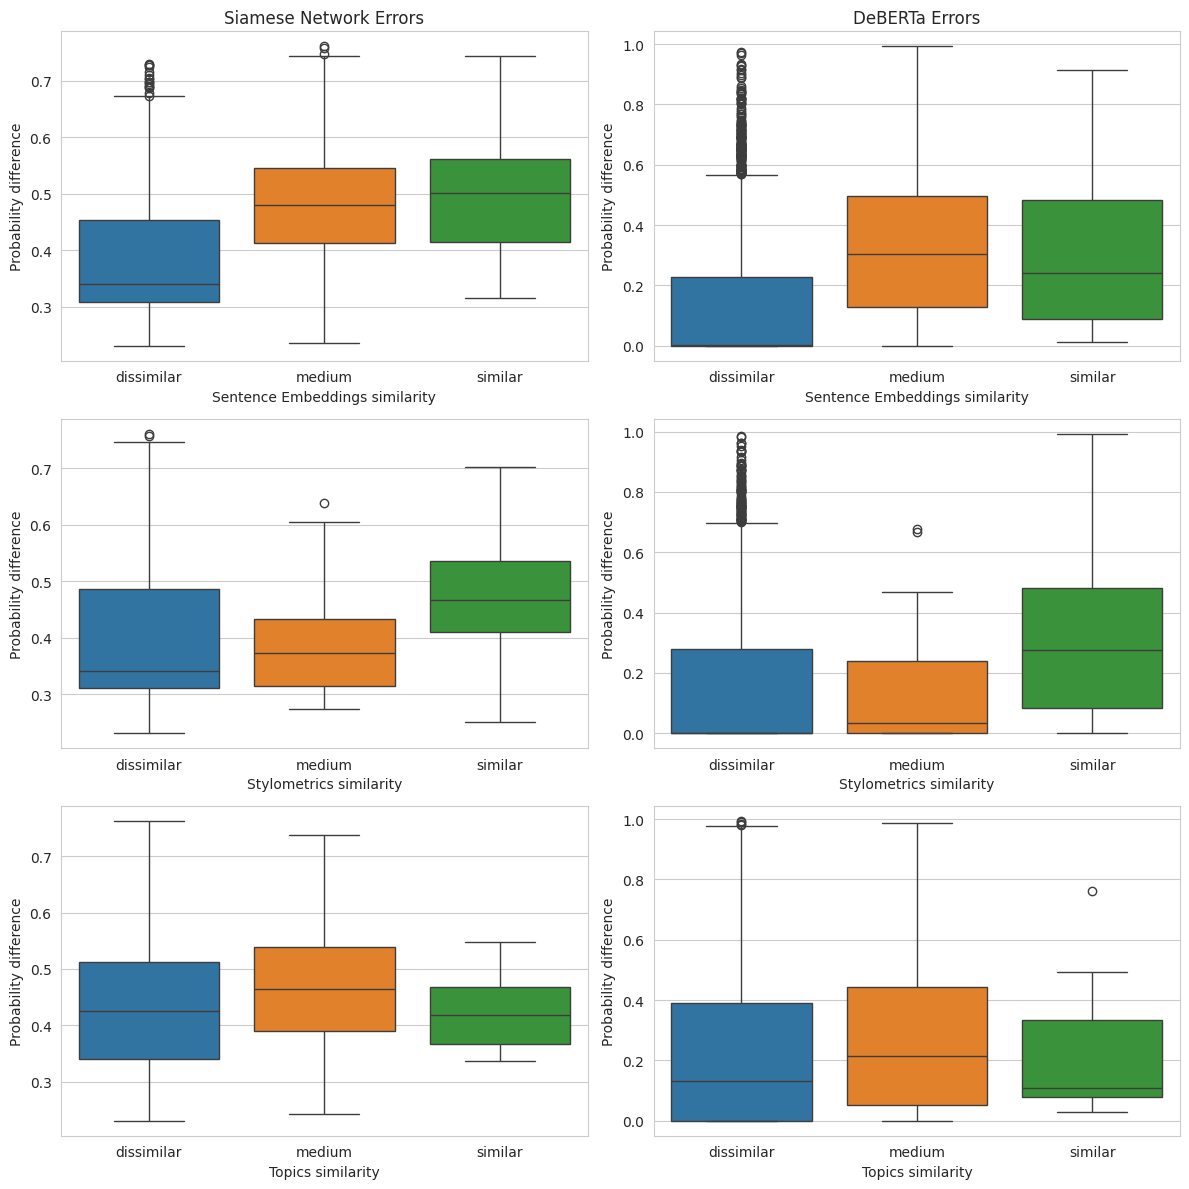

Errors on Embedding similarities
SFN:
   sim_E_bins  target_prediction_match_SFN
0  dissimilar                     0.831741
1      medium                     0.577117
2     similar                     0.497512
DeBERTa:
   sim_E_bins  target_prediction_match_DeB
0  dissimilar                     0.907769
1      medium                     0.756048
2     similar                     0.781095
Errors on Style similarities
SFN:
   sim_F_bins  target_prediction_match_SFN
0  dissimilar                     0.778273
1      medium                     0.812500
2     similar                     0.621596
DeBERTa:
   sim_F_bins  target_prediction_match_DeB
0  dissimilar                     0.890150
1      medium                     0.937500
2     similar                     0.772097
Errors on Topic similarities
SFN:
   sim_T_bins  target_prediction_match_SFN
0  dissimilar                     0.716539
1      medium                     0.606516
2     similar                     0.777778
DeBERTa:
   sim_

<Figure size 640x480 with 0 Axes>

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define a custom color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Set the style
sns.set_style("whitegrid")

# Define figure and axes
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Define bins for similarity measures
test_df['sim_E_bins'] = pd.cut(test_df['sim_E'], 3, labels=['dissimilar', 'medium', 'similar'], right=False)
test_df['sim_F_bins'] = pd.cut(test_df['sim_F'], 3, labels=['dissimilar', 'medium', 'similar'], right=False)
test_df['sim_T_bins'] = pd.cut(test_df['sim_T'], 3, labels=['dissimilar', 'medium', 'similar'], right=False)

titles = {'sim_E_bins': 'Sentence Embeddings', 'sim_F_bins': 'Stylometrics', 'sim_T_bins': 'Topics'}

# Plotting for Siamese network
for i, col in enumerate(['sim_E_bins', 'sim_F_bins', 'sim_T_bins']):
    sns.boxplot(data=test_df, x=col, y="target_probability_diff_SFN", ax=axs[i, 0], palette=colors)
    axs[i, 0].set_ylabel('Probability difference')
    axs[i, 0].set_xlabel('{} similarity'.format(titles[col]))
    axs[i, 0].set_title('Siamese Network Errors' if i == 0 else '')

# Plotting for DeBERTa
for i, col in enumerate(['sim_E_bins', 'sim_F_bins', 'sim_T_bins']):
    sns.boxplot(data=test_df, x=col, y="target_probability_diff_DeB", ax=axs[i, 1], palette=colors)
    axs[i, 1].set_ylabel('Probability difference')
    axs[i, 1].set_xlabel('{} similarity'.format(titles[col]))
    axs[i, 1].set_title('DeBERTa Errors' if i == 0 else '')


# Adjust layout and display plot
plt.tight_layout()
plt.show()


# Adjust layout and display plot
print("Errors on Embedding similarities")
print("SFN:")
print(test_df.groupby('sim_E_bins')['target_prediction_match_SFN'].mean().reset_index().to_string())
print("DeBERTa:")
print(test_df.groupby('sim_E_bins')['target_prediction_match_DeB'].mean().reset_index().to_string())
print("Errors on Style similarities")
print("SFN:")
print(test_df.groupby('sim_F_bins')['target_prediction_match_SFN'].mean().reset_index().to_string())
print("DeBERTa:")
print(test_df.groupby('sim_F_bins')['target_prediction_match_DeB'].mean().reset_index().to_string())
print("Errors on Topic similarities")
print("SFN:")
print(test_df.groupby('sim_T_bins')['target_prediction_match_SFN'].mean().reset_index().to_string())
print("DeBERTa:")
print(test_df.groupby('sim_T_bins')['target_prediction_match_DeB'].mean().reset_index().to_string())

plt.tight_layout()
plt.savefig('/content/drive/My Drive/boxplots.png')